# Install Package

In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install xgboost
!pip install seaborn
!pip install mplcyberpunk calplot
!pip install scikit-learn --upgrade
!pip install holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=d4e788e7902cfac6649090761a06757d1720fad5f09015e73c3d271631f11c48
  Stored in directory: /root/.cache/pip/wheels/ab/5c/33/640389f9acbdab163ff290853439440627fffe75abab4347ad
Successfully built calplot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,

# Import Package

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from calplot import calplot as clp
import mplcyberpunk
plt.style.use("cyberpunk")

from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import gc
import requests
import holidays

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Loading Dataset

In [4]:
df_sales = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/sales.csv", index_col=0, parse_dates=["date"])
df_online = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/online.csv", index_col=0, parse_dates=["date"])
df_markdowns = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/markdowns.csv", index_col=0, parse_dates=["date"])
df_price_history = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/price_history.csv", index_col=0, parse_dates=["date"])
df_discounts_history = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/discounts_history.csv", index_col=0, parse_dates=["date"])
df_actual_matrix = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/actual_matrix.csv", index_col=0, parse_dates=["date"])
df_catalog = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/catalog.csv", index_col=0)
df_stores = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/stores.csv", index_col=0)
df_test = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/test.csv", sep=";", index_col="row_id", parse_dates=["date"], dayfirst = True)
df_sample_submission = pd.read_csv("/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/sample_submission.csv", index_col=0)

# Clean sales.csv

In [5]:
df_sales.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.0000,47.8600,47.8600,1
1,2023-08-04,a66fdf2c0ae7,3.0000,49.6000,148.8000,1
2,2023-08-04,daa46ef49b7a,0.8220,379.0000,311.5400,1
3,2023-08-04,a3b49c1bf758,1.0000,129.0000,129.0000,1
4,2023-08-04,ab611c5cef62,7.0000,79.9000,559.3000,1


In [6]:
df_sales.describe(include="all")

,date,item_id,quantity,price_base,sum_total,store_id
count,7432685,7432685,7432685.0000,7432685.0000,7432685.0000,7432685.0000
unique,NaN,28182,NaN,NaN,NaN,NaN
top,NaN,e5b2b6f57ea7,NaN,NaN,NaN,NaN
freq,NaN,2571,NaN,NaN,NaN,NaN
mean,2023-11-07 01:34:58.084931328,NaN,5.6424,207.5824,761.2796,2.0414
min,2022-08-28 00:00:00,NaN,-500.0000,-21676.6700,-20410.8000,1.0000
25%,2023-05-04 00:00:00,NaN,1.0000,60.0000,127.9000,1.0000
50%,2023-12-25 00:00:00,NaN,2.0000,109.9000,259.6000,2.0000
75%,2024-05-13 00:00:00,NaN,4.6720,199.9000,599.0000,3.0000
max,2024-09-26 00:00:00,NaN,4952.0000,28999.9000,686524.2100,4.0000


In [7]:
df_sales.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

In [8]:
df_sales.duplicated()

0           False
1           False
2           False
3           False
4           False
            ...  
21739585    False
21739586    False
21739587    False
21739588    False
21739589    False
Length: 7432685, dtype: bool

In [9]:
df_sales.drop_duplicates()

,date,item_id,quantity,price_base,sum_total,store_id
0,2023-08-04,293375605257,1.0000,47.8600,47.8600,1
1,2023-08-04,a66fdf2c0ae7,3.0000,49.6000,148.8000,1
2,2023-08-04,daa46ef49b7a,0.8220,379.0000,311.5400,1
3,2023-08-04,a3b49c1bf758,1.0000,129.0000,129.0000,1
4,2023-08-04,ab611c5cef62,7.0000,79.9000,559.3000,1
...,...,...,...,...,...,...
21739585,2024-09-26,542f4875a846,2.0000,419.9000,839.8000,4
21739586,2024-09-26,3c7435256b1f,2.0000,299.9000,599.8000,4
21739587,2024-09-26,87b794255afc,6.0000,499.9000,2999.4000,4
21739588,2024-09-26,0a832c545a6a,1.0000,189.9000,189.9000,4


Delete invalid data

In [10]:
df_sales[(df_sales['quantity'] <= 0) |
         (df_sales['price_base'] <= 0) |
         (df_sales['sum_total'] <= 0)]

,date,item_id,quantity,price_base,sum_total,store_id
1167,2023-08-04,fdba6ef80c19,0.0000,0.0000,0.0000,1
1819,2023-08-04,e30114c99ce6,0.0000,0.0000,0.0000,1
2213,2023-08-04,eabcd9da5a8e,-1.4300,4.9000,-7.0000,1
2301,2023-08-04,779193b74e9b,1.0000,0.0000,0.0000,1
3346,2023-08-04,774d0ac89f51,0.0000,0.0000,0.0000,1
...,...,...,...,...,...,...
21715771,2024-09-22,d53ad3d088d9,0.0000,0.0000,0.0000,4
21726541,2024-09-24,8534715fe09c,0.0000,0.0000,0.9000,4
21733389,2024-09-25,3b6cca6fbf39,0.0000,0.0000,0.9000,4
21734915,2024-09-26,a1df7666038c,0.0000,0.0000,-8.9000,4


In [11]:
mask = (df_sales['quantity'] <= 0) | (df_sales['price_base'] <= 0) | (df_sales['sum_total'] <= 0)
df_sales.drop(df_sales[mask].index, axis=0, inplace=True)

Filter Outliers using IQR - Interquartile Range

# Clean online.csv

In [12]:
df_online.describe(include="all")

,date,item_id,quantity,price_base,sum_total,store_id
count,1123412,1123412,1123412.0000,1123412.0000,1123412.0000,1123412.0000
unique,NaN,18405,NaN,NaN,NaN,NaN
top,NaN,a162df3be29c,NaN,NaN,NaN,NaN
freq,NaN,1047,NaN,NaN,NaN,NaN
mean,2023-10-25 13:29:06.836957184,NaN,2.1948,149.7957,225.9123,1.6594
min,2022-08-28 00:00:00,NaN,0.0020,-8458.3300,-341.8800,1.0000
25%,2023-03-25 00:00:00,NaN,1.0000,43.3400,61.4800,1.0000
50%,2023-12-19 00:00:00,NaN,1.0000,78.6950,110.9600,1.0000
75%,2024-05-09 00:00:00,NaN,2.0000,169.2625,222.9000,1.0000
max,2024-09-26 00:00:00,NaN,999.0000,12171.6200,43556.4400,4.0000


In [13]:
mask_online = (df_online['price_base'] <= 0) | (df_online['sum_total'] <= 0)
df_online.drop(df_online[mask_online].index, axis=0, inplace=True)
df_online[(df_online['price_base'] <= 0) |
         (df_online['sum_total'] <= 0)]

,date,item_id,quantity,price_base,sum_total,store_id


In [14]:
df_online.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

# Clean and Merge sales and actual_matrix

In [15]:
df_actual_matrix.isna().sum()

item_id     0
date        0
store_id    0
dtype: int64

In [16]:
df_actual_matrix['is_available'] = True
df_sales_merged_actual_matrix = pd.merge(df_sales, df_actual_matrix, on=['date', 'item_id', "store_id"], how='left')
df_sales_merged_actual_matrix.isna().sum()

date                  0
item_id               0
quantity              0
price_base            0
sum_total             0
store_id              0
is_available    7422876
dtype: int64

In [17]:
df_sales_merged_actual_matrix.fillna(False, inplace=True)
df_sales_merged_actual_matrix.isna().sum()

date            0
item_id         0
quantity        0
price_base      0
sum_total       0
store_id        0
is_available    0
dtype: int64

# Merge sales and online

In [18]:
df_online = df_online.rename(columns={"price_base":"price_base_online", "sum_total":"sum_total_online"})
df_online["online"] = True

df = pd.merge(df_sales_merged_actual_matrix, df_online, on=['date', 'item_id', "store_id"], how='outer', suffixes=('_x', '_y'))
df["quantity"] = df[['quantity_x', 'quantity_y']].sum(axis=1)

df.isna().sum()

date                       0
item_id                    0
quantity_x            217243
price_base            217243
sum_total             217243
store_id                   0
is_available          217243
quantity_y           6517318
price_base_online    6517318
sum_total_online     6517318
online               6517318
quantity                   0
dtype: int64

In [19]:
df['online'].fillna(False, inplace = True)
df['is_available'].fillna(True, inplace = True)
df.isna().sum()

date                       0
item_id                    0
quantity_x            217243
price_base            217243
sum_total             217243
store_id                   0
is_available               0
quantity_y           6517318
price_base_online    6517318
sum_total_online     6517318
online                     0
quantity                   0
dtype: int64

In [20]:
df.fillna(0, inplace = True)
df.isna().sum()

date                 0
item_id              0
quantity_x           0
price_base           0
sum_total            0
store_id             0
is_available         0
quantity_y           0
price_base_online    0
sum_total_online     0
online               0
quantity             0
dtype: int64

In [21]:
df["sum_total_both"] = df[['sum_total', 'sum_total_online']].sum(axis=1)
df["price_base_both"] = df["sum_total_both"] / df["quantity"]
df[(df['online'] == True)].head()

,date,item_id,quantity_x,price_base,sum_total,store_id,is_available,quantity_y,price_base_online,sum_total_online,online,quantity,sum_total_both,price_base_both
14,2022-08-28,0082d7c4d384,13.6010,276.4000,3759.3100,1,False,0.8000,237.5000,190.0000,True,14.4010,3949.3100,274.2386
19,2022-08-28,00aa37841bff,4.0000,89.7900,359.1400,1,False,1.0000,58.5500,58.5500,True,5.0000,417.6900,83.5380
30,2022-08-28,01b6310ee3bf,0.0000,0.0000,0.0000,1,True,2.0000,26.0800,52.1600,True,2.0000,52.1600,26.0800
45,2022-08-28,021e0d49cd97,2.0000,199.9000,399.8000,1,False,1.0000,168.7400,168.7400,True,3.0000,568.5400,189.5133
48,2022-08-28,023861d4f02f,1.0000,72.0000,72.0000,1,False,1.0000,34.7800,34.7800,True,2.0000,106.7800,53.3900


In [22]:
df = df[['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity', 'sum_total_both', 'price_base_both']]
df.describe(include = "all")

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both
count,7640724,7640724,7640724.0000,7640724,7640724,7640724.0000,7640724.0000,7640724.0000
unique,NaN,28309,NaN,2,2,NaN,NaN,NaN
top,NaN,e5b2b6f57ea7,NaN,False,False,NaN,NaN,NaN
freq,NaN,2569,NaN,7422876,6517318,NaN,NaN,NaN
mean,2023-11-06 11:06:11.422603520,NaN,2.0298,NaN,NaN,5.8119,773.8796,205.0778
min,2022-08-28 00:00:00,NaN,1.0000,NaN,NaN,0.0020,0.0100,0.0050
25%,2023-05-02 00:00:00,NaN,1.0000,NaN,NaN,1.0000,128.1200,59.9000
50%,2023-12-25 00:00:00,NaN,1.0000,NaN,NaN,2.0000,259.8000,109.8000
75%,2024-05-13 00:00:00,NaN,3.0000,NaN,NaN,5.0000,599.7000,199.9000
max,2024-09-26 00:00:00,NaN,4.0000,NaN,NaN,5023.0000,686524.2100,28999.9000


# Clean markdowns.csv

In [23]:
df_markdowns.describe(include="all")

,date,item_id,normal_price,price,quantity,store_id
count,8979,8979,8979.0000,8979.0000,8979.0000,8979.0000
unique,NaN,313,NaN,NaN,NaN,NaN
top,NaN,e7ff6ea67040,NaN,NaN,NaN,NaN
freq,NaN,491,NaN,NaN,NaN,NaN
mean,2023-09-27 17:07:11.807551232,NaN,358.3528,213.2966,3.0705,1.9128
min,2022-08-28 00:00:00,NaN,0.0000,12.5000,0.1150,1.0000
25%,2023-03-16 00:00:00,NaN,189.0000,100.0000,1.0000,1.0000
50%,2023-10-18 00:00:00,NaN,239.0000,150.0000,2.0000,2.0000
75%,2024-04-14 00:00:00,NaN,549.0000,330.0000,4.0000,2.0000
max,2024-09-26 00:00:00,NaN,2790.0000,1380.5000,120.0000,4.0000


In [24]:
mask = (df_markdowns.normal_price <= df_markdowns.price)
df_markdowns[mask]

,date,item_id,normal_price,price,quantity,store_id
168,2023-09-04,44c942fe217c,195.0000,240.0000,11.0000,1
170,2023-09-04,a9d8c085adc0,270.0000,300.0000,32.0000,1
172,2023-09-04,f611e25fa53a,275.0000,320.0000,13.0000,1
177,2023-09-04,76c18abd8f7c,359.0000,390.0000,7.0000,1
1247,2024-03-11,389412076801,119.0000,120.0000,9.0000,1
1251,2024-03-12,389412076801,119.0000,120.0000,3.0000,1
1254,2024-03-13,389412076801,119.0000,120.0000,3.0000,1
1260,2024-03-14,389412076801,119.0000,120.0000,2.0000,1
1307,2024-03-21,389412076801,119.0000,120.0000,1.0000,1
15827,2023-01-09,291d60da77b1,332.9000,339.9000,2.0000,1


In [25]:
df_markdowns.drop(df_markdowns[mask].index, axis=0, inplace=True)

In [26]:
df_markdowns.isna().sum()

date            0
item_id         0
normal_price    0
price           0
quantity        0
store_id        0
dtype: int64

## => Markdown có ảnh hưởng rõ đến Quantity nhưng Markdown ko dự đoán đc??

# Store

In [27]:
df = df.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])
df.drop(["format", 'area'], axis=1, inplace = True)
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2


# Clean discounts_history.csv

In [28]:
df_discounts_history.describe(include="all")

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
count,3746744,3746744,3746744.0000,3746744.0000,3428898.0000,3746744,3746744.0000,3746744.0000
unique,NaN,16081,NaN,NaN,NaN,13763,NaN,NaN
top,NaN,99d388c37359,NaN,NaN,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,NaN,NaN
freq,NaN,34108,NaN,NaN,NaN,196121,NaN,NaN
mean,2024-06-17 11:33:20.464616960,NaN,425.3020,334.0184,5.6623,NaN,286.3346,2.0350
min,2022-08-28 00:00:00,NaN,0.0000,0.0000,1.0000,NaN,1.0000,1.0000
25%,2023-05-01 00:00:00,NaN,84.9000,69.9000,5.0000,NaN,4.0000,1.0000
50%,2024-01-13 00:00:00,NaN,179.9000,149.9000,5.0000,NaN,8.0000,2.0000
75%,2024-06-18 00:00:00,NaN,499.9000,389.9000,6.0000,NaN,13.0000,3.0000
max,2045-12-31 00:00:00,NaN,16999.9000,15999.9000,44.0000,NaN,8766.0000,4.0000


In [29]:
mask = (df_discounts_history.sale_price_before_promo <= df_discounts_history.sale_price_time_promo) | (df_discounts_history.sale_price_before_promo <= 0) | (df_discounts_history.sale_price_time_promo < 0) | (df_discounts_history.date > df_test.date.max())
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
3648341,2022-08-28,68348aae54c8,99.9000,99.9000,10.0000,12f93be4-245e-11ed-ad4d-005056861040,6.0000,1
3648439,2022-08-28,aa6d09435319,799.9000,799.9000,10.0000,12f93be4-245e-11ed-ad4d-005056861040,6.0000,1
3648451,2022-08-28,7428830d55b6,279.9000,279.9000,10.0000,12f93be5-245e-11ed-ad4d-005056861040,6.0000,1
3648481,2022-08-28,8250099a8aff,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,240.0000,1
3648482,2022-08-28,23b18d1f7da9,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,240.0000,1
...,...,...,...,...,...,...,...,...
11420928,2045-12-31,23b18d1f7da9,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420929,2045-12-31,e5b2b6f57ea7,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420930,2045-12-31,2c007023f650,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420931,2045-12-31,9f716dce9a57,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4


In [30]:
df_discounts_history.drop(df_discounts_history[mask].index, axis=0, inplace=True)

In [31]:
df_discounts_history.isna().sum()

date                           0
item_id                        0
sale_price_before_promo        0
sale_price_time_promo          0
promo_type_code            54126
doc_id                         0
number_disc_day                0
store_id                       0
dtype: int64

In [32]:
mask = ((df_discounts_history.date >= df_test.date.min()) & (df_discounts_history.date <= df_test.date.max()))
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
5316258,2024-09-27,8ddf239d0d9b,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1
5316259,2024-09-27,ebf2a6dedec8,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1
5316260,2024-09-27,778fae444c09,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1
5316261,2024-09-27,fcd33abe242f,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1
5316262,2024-09-27,6ab1190bdc2d,389.9000,249.9000,5.0000,45e0c4c5-7b0f-11ef-bb95-005056afbcf1,3.0000,1
...,...,...,...,...,...,...,...,...
11373844,2024-10-25,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,38.0000,4
11373853,2024-10-25,6410dbb30c90,399.9000,299.9000,5.0000,9a579259-7720-11ef-bb94-005056afbcf1,36.0000,4
11373862,2024-10-26,9ee5eded00cf,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4
11373863,2024-10-26,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4


In [33]:
df_discounts_history["discount_percentage"] = (df_discounts_history["sale_price_before_promo"] - df_discounts_history["sale_price_time_promo"]) / df_discounts_history["sale_price_before_promo"]
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id,discount_percentage
5316258,2024-09-27,8ddf239d0d9b,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1,0.1430
5316259,2024-09-27,ebf2a6dedec8,139.9000,119.9000,6.0000,97cec7e9-7a5c-11ef-bb95-005056afbcf1,2.0000,1,0.1430
5316260,2024-09-27,778fae444c09,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1,0.0835
5316261,2024-09-27,fcd33abe242f,59.9000,54.9000,8.0000,d9633ecb-7a75-11ef-bb95-005056afbcf1,2.0000,1,0.0835
5316262,2024-09-27,6ab1190bdc2d,389.9000,249.9000,5.0000,45e0c4c5-7b0f-11ef-bb95-005056afbcf1,3.0000,1,0.3591
...,...,...,...,...,...,...,...,...,...
11373844,2024-10-25,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,38.0000,4,0.2001
11373853,2024-10-25,6410dbb30c90,399.9000,299.9000,5.0000,9a579259-7720-11ef-bb94-005056afbcf1,36.0000,4,0.2501
11373862,2024-10-26,9ee5eded00cf,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4,0.2001
11373863,2024-10-26,67322261c73c,249.9000,199.9000,5.0000,7dc91591-75bf-11ef-bb94-005056afbcf1,39.0000,4,0.2001


# Clean price_history

In [34]:
mask = (df_price_history.price <= 0)
df_price_history.drop(df_price_history[mask].index, axis=0, inplace=True)

# Lấy giá gốc bằng price_history, markdowns, discounts_history

# Merge price vào df

In [35]:
df_price_history = pd.read_csv(r"/kaggle/input/update/price_history_updated.csv", index_col=0, parse_dates=["date"])

In [36]:
df_price_history.duplicated(subset=['item_id', 'store_id', 'date']).sum()

88240

In [37]:
df_price_history = df_price_history.drop_duplicates(subset=['item_id', 'store_id', 'date'], keep='last')

In [38]:
df['price'] = pd.NA

In [39]:

# Lọc giá trị tối đa date <= row['date'] và gộp lại với df_price_history
price_history_filtered = df_price_history[df_price_history['date'] <= df['date'].iloc[0]]
latest_prices = price_history_filtered.groupby(['item_id', 'store_id'])['date'].max().reset_index()
latest_prices = pd.merge(latest_prices, df_price_history, on=['item_id', 'store_id', 'date'], how='left')

# Lọc giá trị tối thiểu date > row['date'] và gộp lại với df_price_history
price_history_filtered_next = df_price_history[df_price_history['date'] > df['date'].iloc[0]]
earliest_prices = price_history_filtered_next.groupby(['item_id', 'store_id'])['date'].min().reset_index()
earliest_prices = pd.merge(earliest_prices, df_price_history, on=['item_id', 'store_id', 'date'], how='left')

# Merge kết quả để có cột giá trị price cho mỗi item_id tại store_id
df = pd.merge(df, latest_prices[['item_id', 'store_id', 'price']], on=['item_id', 'store_id'], how='left', suffixes=('', '_latest'))
df = pd.merge(df, earliest_prices[['item_id', 'store_id', 'price']], on=['item_id', 'store_id'], how='left', suffixes=('', '_earliest'))
# # Sử dụng điều kiện để chọn giá trị cuối cùng (price_latest nếu không có giá trị, chọn price_earliest)
# df['price'] = df['price_latest'].fillna(df['price_earliest'])

# # Xóa các cột tạm thời
# df.drop(['price_latest', 'price_earliest'], axis=1, inplace=True)


In [40]:
print(df.columns)

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'price_latest', 'price_earliest'],
      dtype='object')


In [41]:
# Sử dụng điều kiện để chọn giá trị cuối cùng (price_latest nếu không có giá trị, chọn price_earliest)
df['price'] = df['price_latest'].fillna(df['price_earliest'])

# Xóa các cột tạm thời
df.drop(['price_latest', 'price_earliest'], axis=1, inplace=True)

In [42]:
df.isna().sum()

date                    0
item_id                 0
store_id                0
is_available            0
online                  0
quantity                0
sum_total_both          0
price_base_both         0
division                0
city                    0
price              214640
dtype: int64

In [43]:
df['price'] = df['price'].fillna(df['price_base_both'])

In [44]:
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,119.9000
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000


In [45]:
df.loc[df['price'] < df['price_base_both'], 'price'] = df['price_base_both']
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000


# Merge Discount vào df

In [46]:
columns = df.columns.to_list()
df = df.merge(
    df_discounts_history,
    left_on=['item_id', 'store_id', 'date'],
    right_on=['item_id', 'store_id', 'date'],
    how='left',
    suffixes=('', '_price')
)

df = df[columns + ['discount_percentage', 'number_disc_day']]
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,discount_percentage,number_disc_day
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600,NaN,NaN
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000,NaN,NaN
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000,NaN,NaN
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000,NaN,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000,NaN,NaN


In [47]:
df = df.fillna(0)

# Merge store, discount to test.csv

In [48]:
columns = df_test.columns.to_list()
df_test = df_test.merge(
    df_discounts_history,
    left_on=['item_id', 'store_id', 'date'],
    right_on=['item_id', 'store_id', 'date'],
    how='left',
    suffixes=('', '_price')
)

df_test = df_test.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])


In [49]:
df_test = df_test[columns+['discount_percentage', 'number_disc_day', 'division', 'city']]
df_test.head()

,item_id,store_id,date,discount_percentage,number_disc_day,division,city
0,c578da8e8841,1,2024-09-27,NaN,NaN,Div1,City1
1,c578da8e8841,1,2024-09-28,NaN,NaN,Div1,City1
2,c578da8e8841,1,2024-09-29,NaN,NaN,Div1,City1
3,c578da8e8841,1,2024-09-30,NaN,NaN,Div1,City1
4,c578da8e8841,1,2024-10-01,NaN,NaN,Div1,City1


In [50]:
df_test.isna().sum()

item_id                     0
store_id                    0
date                        0
discount_percentage    840003
number_disc_day        840003
division                    0
city                        0
dtype: int64

In [51]:
df_test = df_test.fillna(0)

# Clean catalog.csv

In [52]:
df_catalog = pd.read_csv(r"/kaggle/input/ml-zoomcamp/ml-zoomcamp-2024-competition/translated_catalog.csv", index_col=0)

In [53]:
df_catalog.head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
Unnamed: 0,,,,,,,,
0,da17e2d5feda,Paper products,Paper products,Wet napkins,NaN,150.0000,NaN,NaN
1,614de2b96018,Paper products,Cotton products,Cotton wheels,NaN,30.0000,NaN,NaN
2,0c1f1f3e3e11,Paper products,Cotton products,Cotton wheels,NaN,NaN,NaN,NaN
3,71a7fa99f005,Home goods,Vessel,COOKWARE,NaN,NaN,NaN,NaN
4,ec1bd4d59fe9,Paper products,Cotton products,Cotton wheels,NaN,30.0000,NaN,NaN


In [54]:
df = df.merge(df_catalog, how='left', left_on=["item_id"], right_on=["item_id"])
df.head()

,date,item_id,store_id,is_available,online,quantity,sum_total_both,price_base_both,division,city,price,discount_percentage,number_disc_day,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,2022-08-28,001829cb707d,1,False,False,7.0000,943.3200,134.7600,Div1,City1,134.7600,0.0000,0.0000,CREAM,CREAM,Drinking cream,Drinking,0.5000,0.5000,10.0000
1,2022-08-28,001829cb707d,2,False,False,1.0000,148.0000,148.0000,Div2,City1,149.9000,0.0000,0.0000,CREAM,CREAM,Drinking cream,Drinking,0.5000,0.5000,10.0000
2,2022-08-28,0022b986c8f0,1,False,False,2.0000,119.8000,59.9000,Div1,City1,69.9000,0.0000,0.0000,"Spices, seasoning",Monitoring,Monitoring,"Spices, seasoning",0.0200,0.0200,NaN
3,2022-08-28,00274a69c705,2,False,False,1.0000,35.9000,35.9000,Div2,City1,35.9000,0.0000,0.0000,Sweet flour products,Biscuit,The cookies are packaged,Biscuit,0.1300,0.1300,NaN
4,2022-08-28,00274a69c705,3,False,False,5.0000,179.5000,35.9000,Div2,City2,35.9000,0.0000,0.0000,Sweet flour products,Biscuit,The cookies are packaged,Biscuit,0.1300,0.1300,NaN


In [55]:
df_test = df_test.merge(df_catalog, how='left', left_on=["item_id"], right_on=["item_id"])
df_test.head()

,item_id,store_id,date,discount_percentage,number_disc_day,division,city,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,c578da8e8841,1,2024-09-27,0.0000,0.0000,Div1,City1,Tobacco products,CIGARETTES,CIGARETTES,NaN,NaN,NaN,NaN
1,c578da8e8841,1,2024-09-28,0.0000,0.0000,Div1,City1,Tobacco products,CIGARETTES,CIGARETTES,NaN,NaN,NaN,NaN
2,c578da8e8841,1,2024-09-29,0.0000,0.0000,Div1,City1,Tobacco products,CIGARETTES,CIGARETTES,NaN,NaN,NaN,NaN
3,c578da8e8841,1,2024-09-30,0.0000,0.0000,Div1,City1,Tobacco products,CIGARETTES,CIGARETTES,NaN,NaN,NaN,NaN
4,c578da8e8841,1,2024-10-01,0.0000,0.0000,Div1,City1,Tobacco products,CIGARETTES,CIGARETTES,NaN,NaN,NaN,NaN


Looking for missing values in the sales and the test dataset

In [56]:
def get_colums_with_nan(df):
    return df.columns[df.isna().sum() > 0]
    
cols = get_colums_with_nan(df)

df[cols].isna().sum()*100/len(df)

dept_name        0.4891
class_name       0.4891
subclass_name    0.4891
item_type        9.1647
weight_volume   19.4029
weight_netto    15.1121
fatness         91.2581
dtype: float64

In [57]:
df_test[cols].isna().sum()*100/len(df_test)

dept_name        6.3485
class_name       6.3485
subclass_name    6.3485
item_type       13.2469
weight_volume   21.9514
weight_netto    16.2446
fatness         94.7787
dtype: float64

In [58]:
df = df.drop(["fatness"], axis=1)
df_test = df_test.drop(["fatness"], axis=1)

Filling missing value

In [59]:
def fill_catalog(dataframe, item_name="other"):
    dataframe.dept_name = dataframe.dept_name.fillna("other")
    dataframe.class_name = dataframe.class_name.fillna("other")
    dataframe.subclass_name = dataframe.subclass_name.fillna("other")
    dataframe.item_type = dataframe.item_type.fillna("other")
    return dataframe

df = fill_catalog(df, item_name="other")
df_test = fill_catalog(df_test, item_name="other")

In [60]:
cols = get_colums_with_nan(df)

Filling in the weight_volume and weight_netto features

In [61]:
def weight_fill_nan(dataframe):
    dataframe.weight_volume = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    return dataframe

train_index = len(df)
test_index = len(df_test)

all_data = pd.concat([df, df_test], axis=0)

all_data = weight_fill_nan(all_data)
df = all_data.iloc[:train_index]
df_test = all_data.iloc[train_index:test_index+train_index]

In [62]:
df = df.fillna(-1)
df[cols].isna().sum()*100/len(df)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

In [63]:
df_test = df_test.fillna(-1)
df_test[cols].isna().sum()*100/len(df_test)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

In [64]:
df_price_history.sort_values(by=['store_id', 'item_id', 'date'], inplace=True)
from collections import defaultdict

price_dict = defaultdict(list)
for row in df_price_history.itertuples(index=False):
    key = (row.store_id, row.item_id)
    price_dict[key].append((row.date, row.price))

In [65]:
from bisect import bisect_right

def get_latest_price(key, date):
    entries = price_dict.get(key, [])
    dates = [d for d, _ in entries]
    idx = bisect_right(dates, date) - 1  # tìm vị trí gần nhất trước ngày
    if idx >= 0:
        return entries[idx][1]
    return None  # hoặc giữ nguyên -1 nếu không có giá nào trước đó

# Áp dụng từng dòng
df_test['price'] = [
    get_latest_price((row.store_id, row.item_id), row.date)
    for row in df_test.itertuples(index=False)
]

In [66]:
df_test.isna().sum()

date                       0
item_id                    0
store_id                   0
is_available               0
online                     0
quantity                   0
sum_total_both             0
price_base_both            0
division                   0
city                       0
price                  38340
discount_percentage        0
number_disc_day            0
dept_name                  0
class_name                 0
subclass_name              0
item_type                  0
weight_volume              0
weight_netto               0
dtype: int64

In [67]:
df_test = df_test.fillna(-1)

# Data visualization

In [68]:
#...

# Feature Engineering

Extracting features of the date column

In [69]:
def date_features(dataframe):
    dataframe["dayofmonth"] = dataframe.date.dt.day
    dataframe["month"] = dataframe.date.dt.month
    dataframe["dayofyear"] = dataframe.date.dt.dayofyear
    dataframe["year"] = dataframe.date.dt.year
    dataframe['dayofweek'] = dataframe['date'].dt.dayofweek 
    dataframe['week'] = dataframe['date'].dt.isocalendar().week
    return dataframe
    
df = date_features(df)
df_test = date_features(df_test)

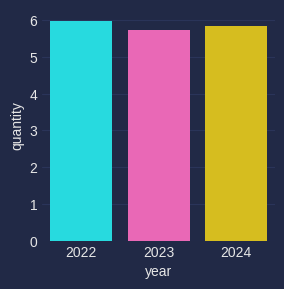

In [70]:
# Quantity per year
plt.figure(figsize=(3, 3))
aux = df.groupby(["year"]).quantity.mean().reset_index()
aux.year = aux.year.apply(str)
sns.barplot(y=aux.quantity, x=aux.year);

In [71]:
def transform2cyclic(dataframe):
    dataframe['dayofmonth_sin'] = np.sin(2 * np.pi * (dataframe['dayofmonth']-1)/31)
    dataframe['dayofmonth_cos'] = np.cos(2 * np.pi * (dataframe['dayofmonth']-1)/31)

    dataframe['dayofyear_sin'] = np.sin(2 * np.pi * (dataframe['dayofyear']-1)/365)
    dataframe['dayofyear_cos'] = np.cos(2 * np.pi * (dataframe['dayofyear']-1)/365)
    
    dataframe['dayofweek_sin'] = np.sin(2 * np.pi * dataframe['dayofweek']/6)
    dataframe['dayofweek_cos'] = np.cos(2 * np.pi * dataframe['dayofweek']/6)
    
    dataframe['week_sin'] = np.sin(2 * np.pi * (dataframe['week']-1)/52)
    dataframe['week_cos'] = np.cos(2 * np.pi * (dataframe['week']-1)/52)
    
    dataframe['month_sin'] = np.sin(2 * np.pi * (dataframe['month']-1)/12)
    dataframe['month_cos'] = np.cos(2 * np.pi * (dataframe['month']-1)/12)
    return dataframe

df = transform2cyclic(df)
df_test = transform2cyclic(df_test)

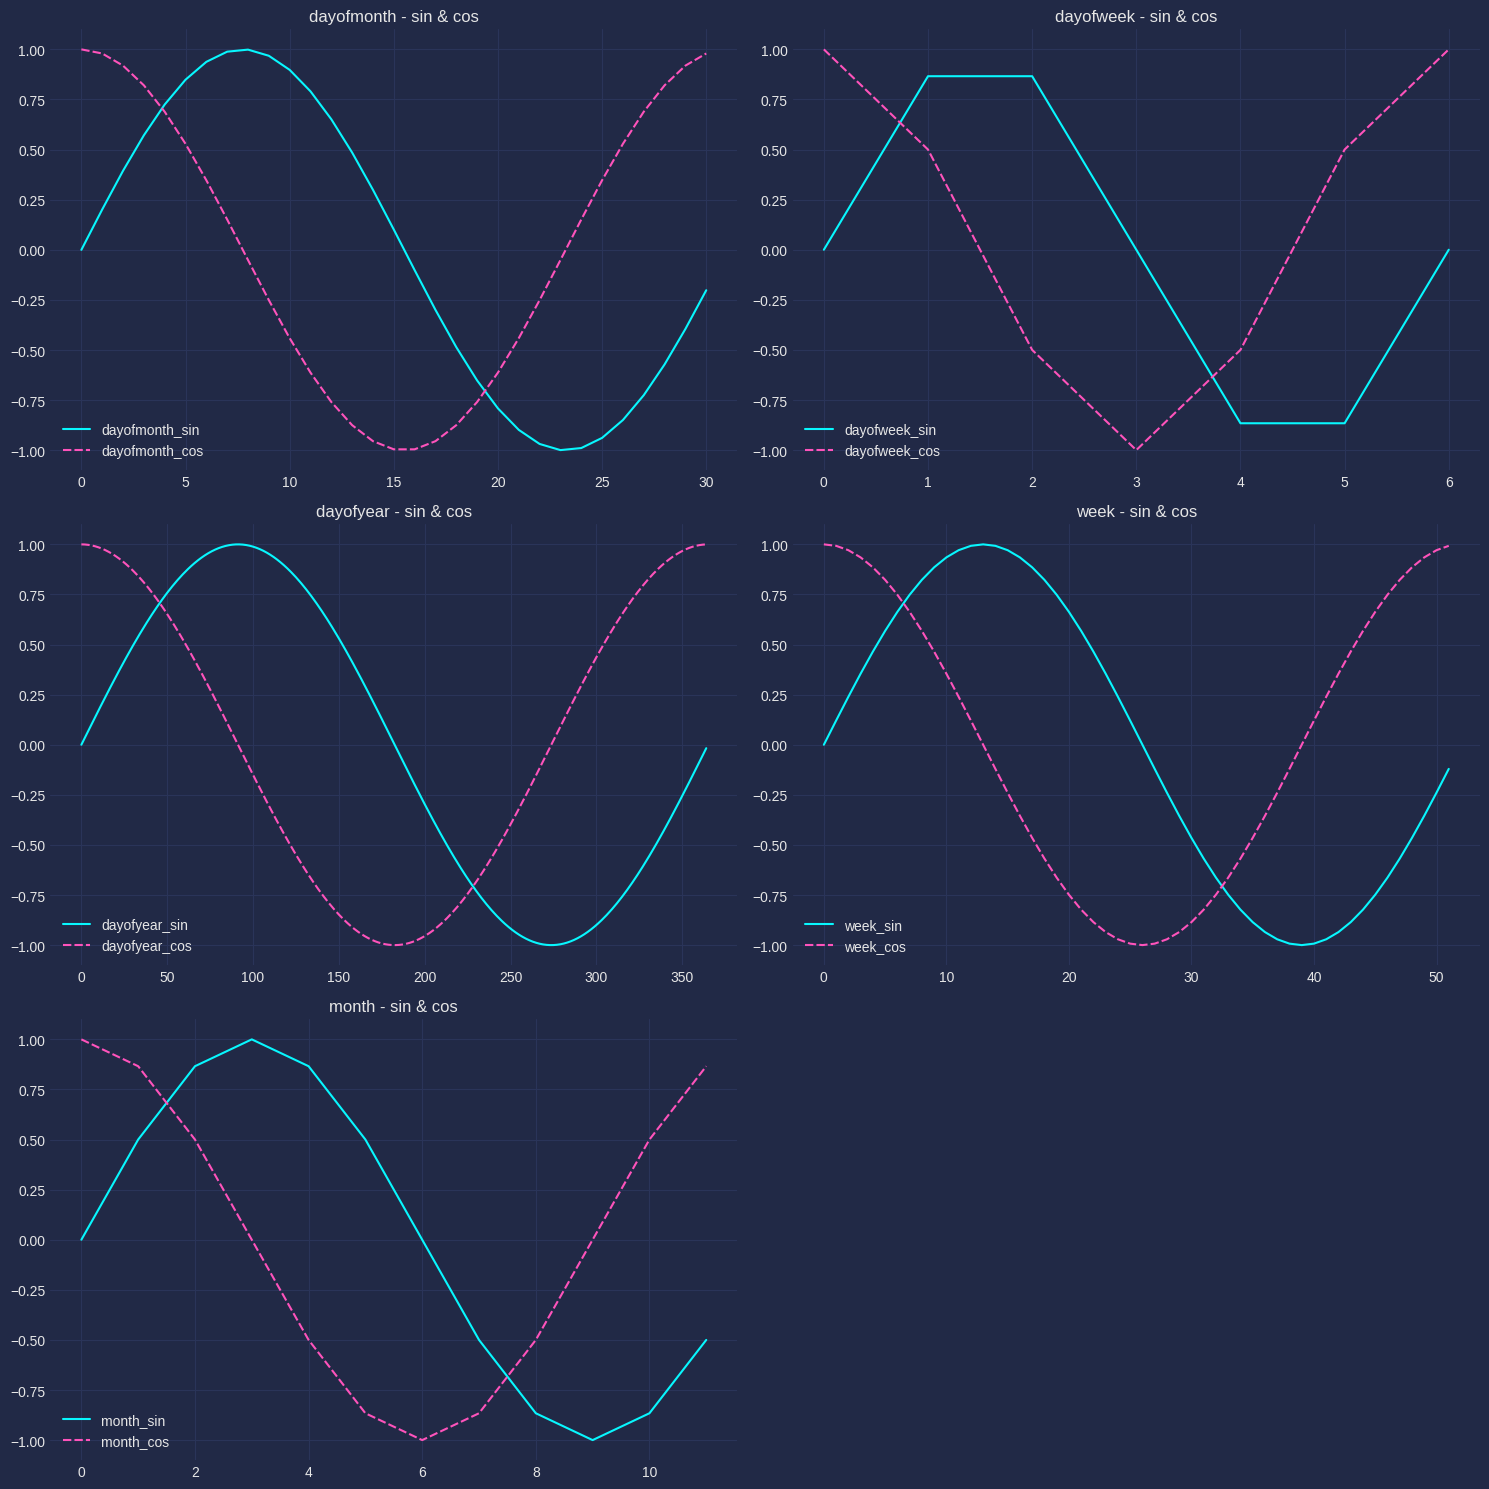

In [72]:
cols = ["dayofmonth", "dayofweek", "dayofyear", "week", "month"]
n = len(cols)
rows = (n + 1) // 2  # 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for i, col in enumerate(cols):
    aux = df.groupby([col, col+"_sin", col+"_cos"]).quantity.mean().reset_index()
    aux[col] = aux[col].apply(str)
    sns.lineplot(data=aux[[col+"_sin", col+"_cos"]], ax=axes[i])
    axes[i].set_title(f"{col} - sin & cos")

# Hide any unused subplots (if n is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [73]:
def get_seasons(dataframe):
    dataframe["season"] = 0
    dataframe.loc[(dataframe.month >= 3) & (dataframe.month <= 5), "season"] = 1
    dataframe.loc[(dataframe.month >= 6) & (dataframe.month <= 8), "season"] = 2
    dataframe.loc[(dataframe.month == 9) & (dataframe.month <= 11), "season"] = 3
    dataframe.loc[((dataframe.month >= 1) & (dataframe.month <= 2)) | (dataframe.month == 12), "season"] = 4
    return dataframe

df = get_seasons(df)
df_test = get_seasons(df_test)

In [74]:
df.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season'],
      dtype='object')

In [75]:
def get_holidays(dataframe):
    RU_holidays = holidays.CountryHoliday('RU', years=[2022, 2023, 2024])
    dataframe["holidays"] = False
    dataframe.loc[df.date.isin(RU_holidays.keys()), "holidays"] = True
    return dataframe

df = get_holidays(df)
df_test = get_holidays(df_test)

In [76]:
def get_sundays(dataframe):
    dataframe["is_sunday"] = dataframe['dayofweek'].eq(6)
    return dataframe

df = get_sundays(df)
df_test = get_sundays(df_test)

In [77]:
def get_weekends(dataframe):
    dataframe["is_weekend"] = dataframe['dayofweek'].isin([4, 5, 6])
    return dataframe

df = get_weekends(df)
df_test = get_weekends(df_test)

In [78]:
df.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season', 'holidays', 'is_sunday', 'is_weekend'],
      dtype='object')

In [79]:
df_test.columns

Index(['date', 'item_id', 'store_id', 'is_available', 'online', 'quantity',
       'sum_total_both', 'price_base_both', 'division', 'city', 'price',
       'discount_percentage', 'number_disc_day', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto',
       'dayofmonth', 'month', 'dayofyear', 'year', 'dayofweek', 'week',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'season', 'holidays', 'is_sunday', 'is_weekend'],
      dtype='object')

In [80]:
cols = ['date', 
        'dayofmonth', 
        'dayofyear',
        'dayofweek', 
        'week', 
        'online',
        'is_available',
        'month', 
        'price_base_both', 
        'sum_total_both',
        'price',
        'is_sunday',
        'is_weekend'
       ]
df.drop(columns=cols, inplace=True)
df_test.drop(columns=cols+["quantity"], inplace=True)

In [81]:
df_test.columns

Index(['item_id', 'store_id', 'division', 'city', 'discount_percentage',
       'number_disc_day', 'dept_name', 'class_name', 'subclass_name',
       'item_type', 'weight_volume', 'weight_netto', 'year', 'dayofmonth_sin',
       'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin',
       'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos',
       'season', 'holidays'],
      dtype='object')

In [82]:
X = df.drop(["quantity"], axis=1)
y = df["quantity"]

In [83]:
numerical_cols = X.select_dtypes([np.int32, np.int64, np.float32, np.float64,bool]).columns.to_list()
categorical_cols = X.select_dtypes('object').columns.to_list()
numerical_cols, categorical_cols

(['store_id',
  'discount_percentage',
  'number_disc_day',
  'weight_volume',
  'weight_netto',
  'year',
  'dayofmonth_sin',
  'dayofmonth_cos',
  'dayofyear_sin',
  'dayofyear_cos',
  'dayofweek_sin',
  'dayofweek_cos',
  'week_sin',
  'week_cos',
  'month_sin',
  'month_cos',
  'season',
  'holidays'],
 ['item_id',
  'division',
  'city',
  'dept_name',
  'class_name',
  'subclass_name',
  'item_type'])

In [84]:
column_transformer = make_column_transformer(
    # Numerical columns
    (
        StandardScaler(),
        numerical_cols
    ),
    # Categorical columns
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        categorical_cols
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transformed = column_transformer.fit_transform(X)
X_test_transformed = column_transformer.transform(df_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [85]:
seed_value = 42
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.8, random_state=seed_value)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6112579, 30374) (6112579,)
(1528145, 30374) (1528145,)


In [86]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.6, log=True),
        "max_depth": trial.suggest_int("max_depth", 10, 14),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "verbosity": 0,
        "seed": seed_value,
    }

    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=20,
        verbose=False
    )
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train final model with best params
best_model = XGBRegressor(
    **study.best_params,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=20,
    tree_method='hist',
    device='cuda',
    seed=seed_value
)
best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)



[I 2025-05-25 09:41:29,857] A new study created in memory with name: no-name-dc1ac08f-5f3c-4642-bb11-c13fe54f3ea9
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-05-25 09:56:38,148] Trial 0 finished with value: 6.697128125693846 and parameters: {'n_estimators': 1361, 'learning_rate': 0.1200721664695321, 'max_depth': 14, 'reg_lambda': 7.330068353631989, 'subsample': 0.5333759685924804, 'colsample_bytree': 0.6390178672417997}. Best is trial 0 with value: 6.697128125693846.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-05-25 10:05:05,206] Trial 1 finished w

Best parameters: {'n_estimators': 3303, 'learning_rate': 0.2474197569131044, 'max_depth': 12, 'reg_lambda': 5.593075789130105, 'subsample': 0.9264686362867505, 'colsample_bytree': 0.7815537284637244}
Best RMSE: 6.215898560649586
[0]	validation_0-rmse:21.65978
[1]	validation_0-rmse:18.44686
[2]	validation_0-rmse:16.26270
[3]	validation_0-rmse:14.66295
[4]	validation_0-rmse:13.61587
[5]	validation_0-rmse:12.97132
[6]	validation_0-rmse:12.35334
[7]	validation_0-rmse:11.98814
[8]	validation_0-rmse:11.64737
[9]	validation_0-rmse:11.40785
[10]	validation_0-rmse:11.17893
[11]	validation_0-rmse:10.90997
[12]	validation_0-rmse:10.71627
[13]	validation_0-rmse:10.56396
[14]	validation_0-rmse:10.38199
[15]	validation_0-rmse:10.23777
[16]	validation_0-rmse:10.07902
[17]	validation_0-rmse:9.96852
[18]	validation_0-rmse:9.83549
[19]	validation_0-rmse:9.74510
[20]	validation_0-rmse:9.68721
[21]	validation_0-rmse:9.54137
[22]	validation_0-rmse:9.47608
[23]	validation_0-rmse:9.42897
[24]	validation_0-rm

NameError: name 'model_file' is not defined

In [87]:
model_file = "xgboost_best_model"
best_model.save_model(f"/kaggle/working/{model_file}.json")

from sklearn.metrics import mean_squared_error
rmse_val = np.sqrt(mean_squared_error(y_val, best_model.predict(X_val)))
print(f"RMSE: {rmse_val:.4f}")

RMSE: 6.2159


# Predict Test

In [88]:
quantity_pred = best_model.predict(X_test_transformed)
df_test["quantity"] = quantity_pred
df_submission = df_test[["quantity"]]
df_submission.head()

,quantity
0,8.4937
1,5.7837
2,5.2442
3,5.3798
4,5.2148


In [89]:
missing_items = df_test[~df_test.item_id.isin(df.item_id)]
missing_items.head()

,item_id,store_id,division,city,discount_percentage,number_disc_day,dept_name,class_name,subclass_name,item_type,...,dayofyear_cos,dayofweek_sin,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,season,holidays,quantity
12750,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,-0.0645,-0.8660,-0.5000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,3.5660
12751,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,-0.0473,-0.8660,0.5000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,3.3508
12752,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,-0.0301,-0.0000,1.0000,-0.9927,-0.1205,-0.8660,-0.5000,3,False,2.8791
12753,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,-0.0129,0.0000,1.0000,-1.0000,-0.0000,-0.8660,-0.5000,3,False,2.8791
12754,4.74E+240,1,Div1,City1,0.0000,0.0000,other,other,other,other,...,0.0043,0.8660,0.5000,-1.0000,-0.0000,-1.0000,-0.0000,0,False,2.8875


In [90]:
df_submission.loc[missing_items.index, "quantity"] = 0

/tmp/ipykernel_35/1049873960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission.loc[missing_items.index, "quantity"] = 0


In [91]:
mask = df_submission.quantity < 0
df_submission[mask]

,quantity
99489,-0.0725
199772,-0.2237
199773,-0.0270
211300,-1.0478
211301,-3.9651
...,...
618362,-0.0087
618363,-0.0087
687188,-0.9135
687189,-2.3444


In [92]:
df_submission.loc[mask, 'quantity'] = 0

/tmp/ipykernel_35/1216096653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission.loc[mask, 'quantity'] = 0


In [93]:
df_submission.to_csv("/kaggle/working/submission-best-xgboost.csv", index_label='row_id')